In [342]:
import pandas as pd
from tqdm.notebook import tqdm
import snscrape.modules.twitter as sntwitter

import torch
import re

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax


import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from scipy.special import softmax

In [48]:
# # lod pre-trained Roberta model
from transformers import RobertaForSequenceClassification, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')




OSError: Unable to load weights from pytorch checkpoint file for 'C:\Users\ACER/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\pytorch_model.bin' at 'C:\Users\ACER/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\pytorch_model.bin'. If you tried to load a PyTorch model from a TF 2.0 checkpoint, please set from_tf=True.

In [178]:
scraper = sntwitter.TwitterSearchScraper("mkbhd: iPhone")

tweets = []

# for i, tweet in enumerate(scraper.get_items()):
#     data = [
#         tweet.date,
#         tweet.id,
#         tweet.rawContent,
#         tweet.user.username,
#         tweet.likeCount,
#         tweet.retweetCount,
#     ]
#     tweets.append(data)
#     if i > 150:
#         break

for i, tweet in enumerate(scraper.get_items()):
    data = [
        tweet.date,
        # tweet.id,
        tweet.rawContent,
        tweet.user.username,
        # tweet.likeCount,
        # tweet.retweetCount,
    ]
    tweets.append(data)
    if i > 150:
        break

# print(tweets)

In [179]:
tweet_df = pd.DataFrame(tweets, columns = ["date", "text", "username"])

# print(tweet_df)

In [180]:
def preprocess(df):
    inputs = []
    for tweet in df['text']:
        # Clean the tweet by removing mentions and links
        tweet = re.sub(r"@[A-Za-z0-9]+", "", tweet)  # remove mentions
        tweet = re.sub(r"https?://[A-Za-z0-9./]+", "", tweet)  # remove links
        
        # Tokenize the cleaned tweet and convert it to input tensors
        # encoded_tweet = tokenizer(tweet, return_tensors = "pt")
        encoding = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True)
        # input_ids = encoding['input_ids']
        # attention_mask = encoding['attention_mask']
        # inputs.append((input_ids, attention_mask))
        inputs.append(encoding)
    return inputs

inputs = preprocess(tweet_df)
# print(inputs)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [162]:
# download model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ["Negative", "Neutral", "Positive"]

In [196]:
# Sentiment Analysis
sentiment_results = []
for input in inputs:
    # run through roberta sentiment analysis model
    output = model(**input)

    # convert to probability so score are only between 0 and 1
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    # print(scores)

    # for i in range(len(scores)):
    #     l = labels[i]
    #     s = scores[i]

    sentiment_results.append(scores)


print(sentiment_results)



[array([0.7245386 , 0.24091867, 0.0345427 ], dtype=float32), array([0.7193861 , 0.25331813, 0.02729579], dtype=float32), array([0.1138112 , 0.43998063, 0.44620815], dtype=float32), array([0.05892144, 0.25102964, 0.6900489 ], dtype=float32), array([0.94087076, 0.05303213, 0.00609712], dtype=float32), array([0.00307558, 0.04572709, 0.95119727], dtype=float32), array([0.08998917, 0.519544  , 0.39046684], dtype=float32), array([0.88326055, 0.09838251, 0.01835697], dtype=float32), array([0.7395638 , 0.20523669, 0.05519952], dtype=float32), array([0.00406792, 0.1280718 , 0.86786026], dtype=float32), array([0.00399771, 0.27198815, 0.7240141 ], dtype=float32), array([0.02779398, 0.19012351, 0.78208256], dtype=float32), array([0.13260987, 0.58834016, 0.2790499 ], dtype=float32), array([0.00392496, 0.3283613 , 0.66771376], dtype=float32), array([0.01936672, 0.17961752, 0.8010157 ], dtype=float32), array([0.00275458, 0.19747342, 0.79977196], dtype=float32), array([0.00572162, 0.16192919, 0.832349

In [338]:
# create variables to separate results of each tweet. if it is negative, neutral or porsitive.
negative_results = []
neutral_results = []
positive_results = []

# loop through the sentiment_results list and filter out the results according to its label index. index 0 for negative, 1 for neutral, 2 for positive 
for result in sentiment_results:
    if result[0] > result[1] > result[2]:
        negative_results.append(result[0])
    elif result[1] > result[0] > result[2]:
        neutral_results.append(result[1])
    if result[2] > result[1] > result[0]:
        positive_results.append(result[2])
        

results_by_label = []

results_by_label.append(negative_results)
results_by_label.append(neutral_results)
results_by_label.append(positive_results)



# print(results_by_label[0])
# print(results_by_label[1])
# print(results_by_label[2])

# final_results = [{"Negative": negative_results,
#                   "Neutral": neutral_results,
#                   "Positive": positive_results}]

print(results_by_label)

[[0.7245386, 0.7193861, 0.94087076, 0.88326055, 0.7395638, 0.7473144, 0.7658752, 0.85890585, 0.5154213, 0.8524873, 0.5373604, 0.7790604, 0.67416847, 0.7441432, 0.8564643, 0.7464415, 0.55885184, 0.6955509, 0.7289247, 0.9155438, 0.64926314, 0.95000684, 0.8964949, 0.62376964, 0.8940058, 0.637081, 0.47713012, 0.5158376, 0.7583803, 0.6079664, 0.6775418], [0.8189367, 0.64954454, 0.6985816, 0.59165037, 0.7250231, 0.4937951, 0.8376587, 0.49851513, 0.7132776, 0.8275992, 0.640869, 0.61620754, 0.6653224, 0.58242106, 0.48191625], [0.44620815, 0.6900489, 0.95119727, 0.86786026, 0.7240141, 0.78208256, 0.66771376, 0.8010157, 0.79977196, 0.8323492, 0.35707092, 0.9134419, 0.7176609, 0.90752083, 0.8600859, 0.8589787, 0.97985655, 0.9778842, 0.88336146, 0.54950696, 0.96806294, 0.7064424, 0.90409195, 0.9856719, 0.7328347, 0.80779696, 0.8739996, 0.6066012, 0.69335407, 0.88565016, 0.8944569, 0.95501333, 0.6932588, 0.59665835, 0.98392975, 0.9448068, 0.9672259, 0.97405607, 0.8727386, 0.81691283, 0.85399777, 0.

In [343]:
data = {"Negative": len(negative_results), "Neutral": len(neutral_results), "Positive": len(positive_results)}

sentiment_results_df = list(data.keys())
values = list(data.values())

# sentiment_results_df.head()

<BarContainer object of 3 artists>

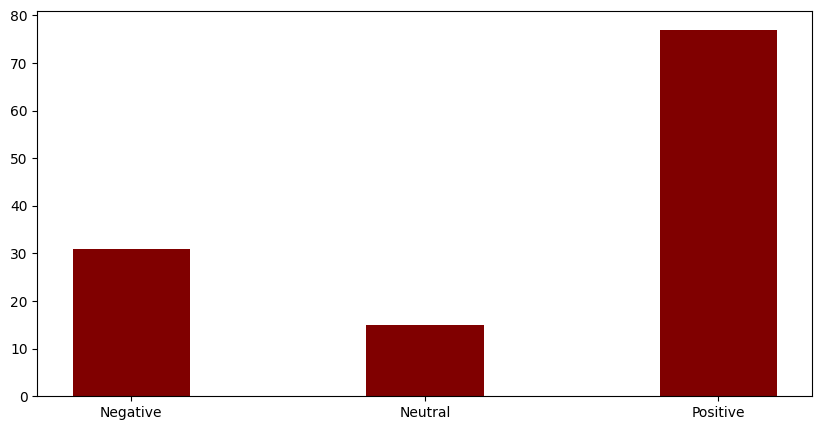

In [344]:
fig = plt.figure(figsize = (10, 5))

plt.bar(sentiment_results_df, values, color = "maroon", width = 0.4)

In [296]:
# sentiment analysis
# sentiments = []
# for input_ids, attention_mask in tqdm(inputs):
#     outputs = model(input_ids, attention_mask=attention_mask)
#     logits = outputs.logits
#     sentiment = torch.argmax(logits, dim=1).item()
#     sentiments.append(sentiment)


In [335]:
sentiment_3 = sentiment_results_df.explode('Positive').reset_index(drop=True)
sentiment_3


,Negative,Neutral,Positive
0,0.724539,"[0.8189367, 0.64954454, 0.6985816, 0.59165037,...",0.446208
1,0.724539,"[0.8189367, 0.64954454, 0.6985816, 0.59165037,...",0.690049
2,0.724539,"[0.8189367, 0.64954454, 0.6985816, 0.59165037,...",0.951197
3,0.724539,"[0.8189367, 0.64954454, 0.6985816, 0.59165037,...",0.86786
4,0.724539,"[0.8189367, 0.64954454, 0.6985816, 0.59165037,...",0.724014
...,...,...,...
2382,0.677542,"[0.8189367, 0.64954454, 0.6985816, 0.59165037,...",0.974381
2383,0.677542,"[0.8189367, 0.64954454, 0.6985816, 0.59165037,...",0.645483
2384,0.677542,"[0.8189367, 0.64954454, 0.6985816, 0.59165037,...",0.991465
2385,0.677542,"[0.8189367, 0.64954454, 0.6985816, 0.59165037,...",0.503061


In [332]:
sentiment_3 = sentiment_3.explode('Neutral').reset_index(drop=True)
sentiment_3

,Negative,Neutral,Positive
0,0.724539,0.818937,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
1,0.724539,0.649545,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
2,0.724539,0.698582,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
3,0.724539,0.59165,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
4,0.724539,0.725023,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
...,...,...,...
460,0.677542,0.640869,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
461,0.677542,0.616208,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
462,0.677542,0.665322,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
463,0.677542,0.582421,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."


In [300]:
sentiment_results_df = sentiment_results_df.reset_index(drop = True)
sentiment_results_df


,Negative,Neutral,Positive
0,0.724539,0.818937,0.446208
1,0.724539,0.818937,0.690049
2,0.724539,0.818937,0.951197
3,0.724539,0.818937,0.86786
4,0.724539,0.818937,0.724014
...,...,...,...
35800,0.677542,0.481916,0.974381
35801,0.677542,0.481916,0.645483
35802,0.677542,0.481916,0.991465
35803,0.677542,0.481916,0.503061


In [288]:
sentiment_results_df = sentiment_results_df.explode('Neutral', 'Positive')

In [289]:
sentiment_results_df = sentiment_results_df.reset_index(drop = True)
sentiment_results_df


,Negative,Neutral,Positive
0,0.724539,0.818937,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
1,0.724539,0.649545,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
2,0.724539,0.698582,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
3,0.724539,0.59165,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
4,0.724539,0.725023,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
...,...,...,...
460,0.677542,0.640869,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
461,0.677542,0.616208,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
462,0.677542,0.665322,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."
463,0.677542,0.582421,"[0.44620815, 0.6900489, 0.95119727, 0.86786026..."


In [60]:
# download model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ["Negative", "Neutral", "Positive"]

In [51]:
# Sentiment analysis
encoded_tweet = tokenizer(inputs, return_tensors = "pt")
# output = model(encoded_tweet["input_ids"], encoded_tweet["attention_mask"])
output = model(**encoded_tweet)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

for i in range(len(scores)):
    l = labels[i]
    s = scores[i]
    print(l, s)

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).